In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid

from tools.misc_tools import get_h5_data
from matplotlib.colors import Normalize, LightSource
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# **Windowing Technique:**

In [2]:

from tools.misc_tools import get_fpath_sim
from tools.plotter import plot_from_array
from tools.kolmogorov import TimeStepper3D
import copy 

material_params = {'W': 20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
system_params = {'Lx': 3*np.pi,  'Lz': np.pi, 'ndim': 3, 'n':1}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 32}

system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix='recent-periodic', subdir='arrowhead_3D', s=-1)

x, y, z = data_fields['x'], data_fields['y'], data_fields['z']

fields = ['p', 'c11', 'c12', 'c22', 'u', 'v']

p = data_fields['p'][-1,:,:,:] - base_flow['p'][[0], None, :]
c11 = data_fields['c11'][-1,:,:,:] - base_flow['c11'][[0], None, :]
c12 = data_fields['c12'][-1,:,:,:] - base_flow['c12'][[0], None, :]
c22 = data_fields['c22'][-1,:,:,:] - base_flow['c22'][[0], None, :]
c33 = data_fields['c33'][-1,:,:,:] - base_flow['c33'][[0], None, :]
u = data_fields['u'][-1,:,:,:] - base_flow['u'][[0], None, :]
trace = c11 + c22 + c33


2025-04-07 10:04:29,977 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


In [3]:
Lx = system_params['Lx']
Nx = solver_params['Nx']
Ny = solver_params['Ny']
Nz = solver_params['Nz']

In [4]:
from cfd_tools.cartesian_systems.misc_tools import shift_reflect

mean_c22_y = np.mean(c22, axis=(0,1))

Ny = mean_c22_y.shape[0]
if mean_c22_y[0] > mean_c22_y[Ny//2]:
    u = shift_reflect(u, parity='odd')
    # v = shift_reflect(v, parity='even')
    p = shift_reflect(p, parity='even')
    trace = shift_reflect(trace, parity='even')
    c22 = shift_reflect(c22, parity='even')

In [5]:
def draw_surface(array1, x, y, z, ax=None, level_mult=0.7, color='tab:blue', zorder=1, level_val=None):

    if level_val is None:
        level_val = (np.max(array1) - np.min(array1)) * level_mult + np.min(array1)

    try:
        verts, faces, _, _ = marching_cubes(array1, level=level_val, step_size=1, spacing=(x[1]-x[0], y[1]-y[0], z[1]-z[0]))
        
        verts[:, 0] += x[0]
        verts[:, 1] += y[0]
        verts[:, 2] += z[0]

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        ls = LightSource(azdeg=45.0, altdeg=245.0)
        mesh = Poly3DCollection(verts[faces], shade=True, lightsource=ls, facecolors=color, zorder=zorder)

        ax.add_collection3d(mesh)
    except:
        pass

    return verts, level_val

In [6]:

def plot_3D_surface(array1, x, y, z, ax=None, level_mult=0.7, level_val=None, zorder=1):
    if not np.all(np.isclose(np.diff(x, n=2), 0)) or not np.all(np.isclose(np.diff(y, n=2), 0)) or not np.all(np.isclose(np.diff(z, n=2), 0)):
        raise Exception("Grids not equally spaced. Marching Cube Algorithm will be weird...")
    x, y, z = x, z, y

    if ax is None:
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel("x", labelpad=20, fontsize=32)
        ax.set_ylabel("z", labelpad=40, fontsize=32)
        ax.set_zlabel("y",labelpad=10, fontsize=32)

        ax.view_init(elev=30, azim=25, roll=0)

    if isinstance(level_mult, float) or level_mult is None: 
        verts, level_val = draw_surface(array1, x, y, z, ax, level_mult, 'tab:blue', zorder, level_val)
    elif isinstance(level_mult, list):
        verts, level_val = draw_surface(array1, x, y, z, ax, level_mult[0], 'tab:red', zorder)
        verts, level_val = draw_surface(array1, x, y, z, ax, level_mult[1], 'tab:red', zorder)

    plt.tight_layout()

    return ax, verts, level_val

In [7]:
def get_activity(field, x, y):
    field_2  = np.array(field) ** 2 
    field_2_x = trapezoid(field_2, x, axis=0) / (3*np.pi)
    field_2_xy = trapezoid(field_2_x, y, axis=-1) / (2*np.pi)
    field_xy = field_2_xy ** 0.5
    return field_xy

In [27]:
# Tile the periodic solution...
roll_x = -3
roll_z = -6

trace_trans = np.roll(trace, shift=roll_x, axis=0)
trace_trans = np.roll(trace_trans, shift=roll_z, axis=1)
trace_tiled = np.tile(trace_trans, (1, 5, 1))
trace_tiled = trace_tiled[:, Nz//2:-Nz//2, :]

p_trans = np.roll(p, shift=roll_x, axis=0)
p_trans = np.roll(p_trans, shift=roll_z, axis=1)
p_tiled = np.tile(p_trans, (1, 5, 1))
p_tiled = p_tiled[:, Nz//2:-Nz//2, :]

u_trans = np.roll(u, shift=roll_x, axis=0)
u_trans = np.roll(u_trans, shift=roll_z, axis=1)
u_tiled = np.tile(u_trans, (1, 5, 1))
u_tiled = u_tiled[:, Nz//2:-Nz//2, :]


x_tiled = x
y_tiled = y
z_tiled = np.concatenate([z-2*np.pi, z-1*np.pi, z , z+1*np.pi, z+2*np.pi])[Nz//2:-Nz//2]

Nz_tiled = Nz * 4




/tmp/ipykernel_17510/3400525163.py:143: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


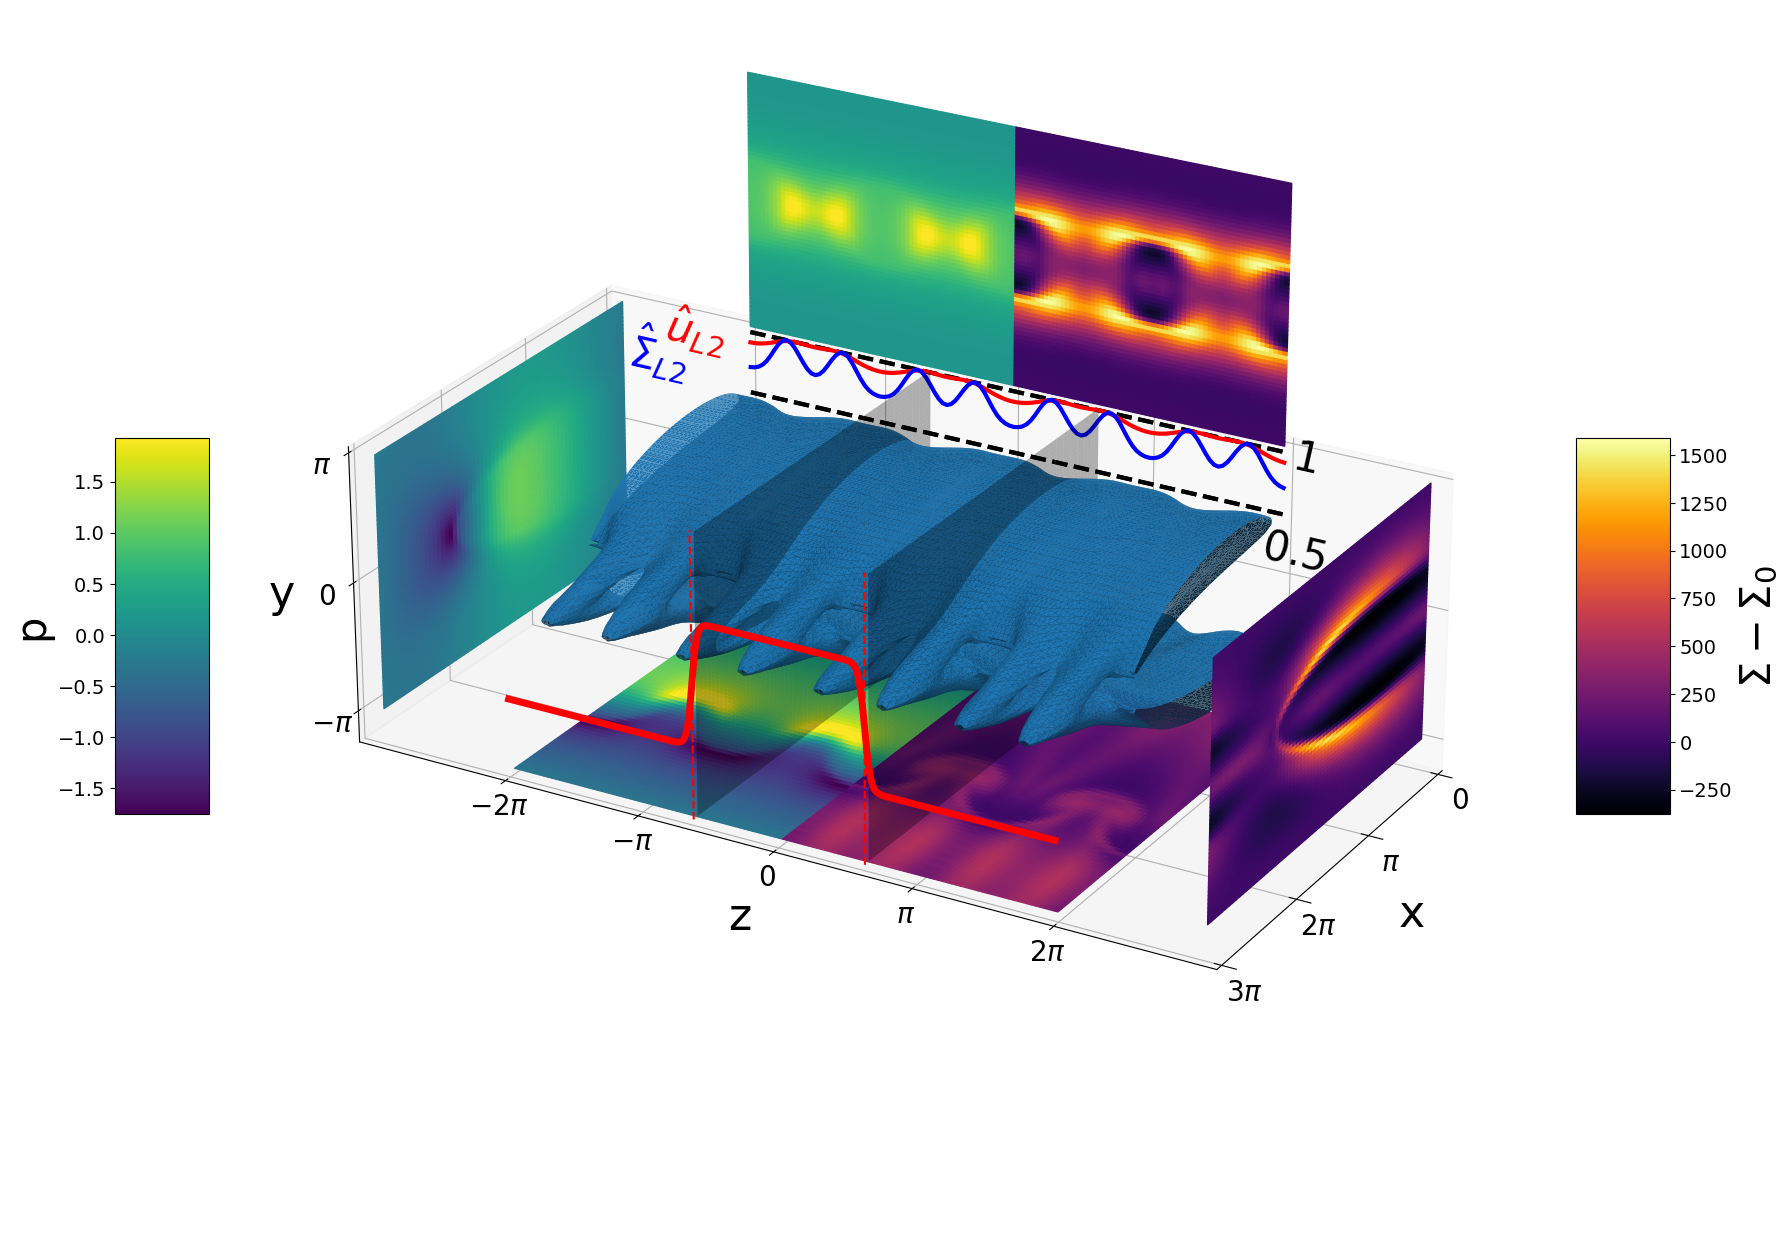

In [28]:
a, b = np.pi/2, np.pi/4
plt.rcParams['font.size'] = 40

z_idx_ab = np.argmin(np.abs(z_tiled-a-0.5*b))
z_idx__ab = np.argmin(np.abs(z_tiled+a+0.5*b))

ax, verts, level_val = plot_3D_surface(trace_tiled[:,:z_idx__ab+1,:], x_tiled, y_tiled, z_tiled[:z_idx__ab+1], ax=None, zorder=0.2, level_val=450)
ax, verts, level_val = plot_3D_surface(trace_tiled[:,z_idx__ab:z_idx_ab+1,:], x_tiled, y_tiled, z_tiled[z_idx__ab:z_idx_ab+1], ax=ax, zorder=0.5, level_val=450)
ax, verts, level_val = plot_3D_surface(trace_tiled[:,z_idx_ab:,:], x_tiled, y_tiled, z_tiled[z_idx_ab:], ax=ax, zorder=0.6, level_val=450)
ax.computed_zorder = False

ax.view_init(elev=25, azim=30, roll=0)

ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$'], fontsize=20)
ax.set_zticks([-np.pi, 0, np.pi, ], [r'$-\pi$', '0', r'$\pi$'], fontsize=20)
ax.set_yticks([0, 1*np.pi, 2*np.pi, -1*np.pi, -2*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$-\pi$', r'$-2\pi$'], fontsize=20)

ax.computed_zorder = False

ax.set_xlim(0, 3*np.pi)  
ax.set_ylim(-3*np.pi, 3*np.pi)  

ax.set_zlim((-1.2*np.pi, np.pi))

ax.set_box_aspect((3*np.pi, 6*np.pi, 2*np.pi), zoom=0.9)

#### Plot windowing function

z_plot = np.linspace(np.min(z_tiled), np.max(z_tiled), 300)
window = 1/4 * (1 + np.tanh(6 * (a - z_plot) / b + 3)) * (1 + np.tanh(6 * (a + z_plot) / b + 3))

color = 'red'
ax.plot(z_plot, (window*3-2), zs=Lx, zdir='x', color=color, zorder=10, linewidth=5)

ax.plot([-a-0.5*b, -a-0.5*b], [-1.2*np.pi, np.pi], zs=Lx, zdir='x', color=color, linestyle='--', zorder=10)
ax.plot([a+0.5*b, a+0.5*b], [-1.2*np.pi, np.pi], zs=Lx, zdir='x', color=color, linestyle='--', zorder=10)

#### Plot windowing planes
xgrid, ygrid = np.meshgrid(x_tiled, y_tiled, sparse=False, indexing='ij')
ygrid = 1.1*ygrid - 0.3

ax.plot_surface(xgrid, (a+0.5*b) * np.ones_like(xgrid), ygrid, rstride=1, cstride=1,
                            color='k', shade=False, zorder=0.55, alpha=0.3)

ax.plot_surface(xgrid, -(a+0.5*b) * np.ones_like(xgrid), ygrid, rstride=1, cstride=1,
                            color='k', shade=False, zorder=0.25, alpha=0.3)

#### Plot periodicity
u_metric = get_activity(u_tiled, x_tiled, y_tiled)
u_metric = u_metric / np.max(u_metric)
ax.plot(z_tiled, u_metric*3 , zs=0, zdir='x', color='red', zorder=0.05, linewidth=3)
ax.plot(z_tiled, 1.5 * np.ones_like(z_tiled), zs=0, zdir='x', color='black', linestyle='--', zorder=0.01, linewidth=3)
ax.plot(z_tiled, 3 * np.ones_like(z_tiled), zs=0, zdir='x', color='black', linestyle='--', zorder=0.01, linewidth=3)
trace_metric = get_activity(trace_tiled, x_tiled, y_tiled)
trace_metric = trace_metric / np.max(trace_metric)
ax.plot(z_tiled, trace_metric*3, zs=0, zdir='x', color='blue', zorder=0.05, linewidth=3)
ax.plot(z_tiled, 1.5 * np.ones_like(z_tiled), zs=0, zdir='x', color='black', linestyle='--', zorder=0.01, linewidth=3)
ax.plot(z_tiled, 3 * np.ones_like(z_tiled), zs=0, zdir='x', color='black', linestyle='--', zorder=0.01, linewidth=3)

ax.text(0,-2.7*np.pi, 2, r'$\hat u_{L2}$', 'y', color='red', fontsize=30)
ax.text(0,-3*np.pi, 1.1, r'$\hat \Sigma_{L2}$', 'y', color='blue', fontsize=30)
ax.text(0,1.8*np.pi, -0 *np.pi, r'$0.5$','y',  color='black', fontsize=30)
ax.text(0,2*np.pi, 0.8*np.pi, r'$1$', 'y', color='black', fontsize=30)


### Get key p, trace terms
min_p, max_p = np.min(p), np.max(p) * 0.9
min_tr, max_tr = np.min(trace), np.max(trace)

cmap_kind_p = 'viridis'
cmap_p = plt.get_cmap(cmap_kind_p)
cmap_kind_tr = 'inferno'
cmap_tr = plt.get_cmap(cmap_kind_tr)

norm_p = Normalize(vmin=min_p, vmax=max_p)
sm_p = plt.cm.ScalarMappable(cmap=cmap_kind_p, norm=norm_p)
norm_tr = Normalize(vmin=min_tr, vmax=max_tr)
sm_tr = plt.cm.ScalarMappable(cmap=cmap_kind_tr, norm=norm_tr)

### Get x-z plane

xgrid, zgrid = np.meshgrid(x_tiled, z_tiled, sparse=False, indexing='ij')

p_plane = p_tiled[:,:,Ny//2]
tr_plane = trace_tiled[:,:,Ny//2]

p_plane, xgrid_p, zgrid_p = p_plane[:,:Nz_tiled//2+1], xgrid[:, :Nz_tiled//2+1], zgrid[:,:Nz_tiled//2+1]
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))
tr_plane, xgrid_tr, zgrid_tr = tr_plane[:,Nz_tiled//2:], xgrid[:, Nz_tiled//2:], zgrid[:, Nz_tiled//2:]
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(xgrid_p, zgrid_p, -1.2*np.pi * np.ones_like(xgrid_p), rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.1)
ax.plot_surface(xgrid_tr, zgrid_tr, -1.2*np.pi * np.ones_like(xgrid_tr), rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=0.1)

### Get x-y plane

xgrid, ygrid = np.meshgrid(x_tiled, y_tiled, sparse=False, indexing='ij')

p_plane = p_tiled[:,Nz_tiled//2,:]
tr_plane = trace_tiled[:,Nz_tiled//2,:]

p_plane, xgrid_p, ygrid_p = p_plane, xgrid, ygrid
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))
tr_plane, xgrid_tr, ygrid_tr = tr_plane, xgrid, ygrid
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(xgrid_p, -3*np.pi * np.ones_like(xgrid_p), ygrid_p, rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.1)
ax.plot_surface(xgrid_tr, 3*np.pi * np.ones_like(xgrid_tr), ygrid_tr, rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=5)


## Get y-z plane

zgrid, ygrid = np.meshgrid(z_tiled, y_tiled, sparse=False, indexing='ij')

p_plane = p_tiled[Nx//2,:,:]
tr_plane = trace_tiled[Nx//2,:,:]

p_plane, zgrid_p, ygrid_p = p_plane[:Nz_tiled//2+1,:], zgrid[:Nz_tiled//2+1,:], ygrid[:Nz_tiled//2+1,:]
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))

tr_plane, zgrid_tr, ygrid_tr = tr_plane[Nz_tiled//2:,:], zgrid[Nz_tiled//2:,:], ygrid[Nz_tiled//2:,:]
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(np.zeros_like(zgrid_p), zgrid_p, ygrid_p+2*np.pi, rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.01)
ax.plot_surface(np.zeros_like(zgrid_tr), zgrid_tr, ygrid_tr+2*np.pi, rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=0.01)


sm_p.set_array([])  # Necessary for ScalarMappable to work with colorbar
cbar = plt.colorbar(sm_p, ax=ax, shrink=0.2, aspect=4, location='left', pad=0.03)
cbar.set_label(label='p', size=30)

sm_tr.set_array([])  # Necessary for ScalarMappable to work with colorbar
cbar = plt.colorbar(sm_tr, ax=ax, shrink=0.2, aspect=4, location='right')
cbar.set_label(label=r'$\Sigma - \Sigma_0$', size=30)


plt.tight_layout()

# Localisation

In [29]:
material_params = {'W': 20, 'beta': 0.9, 'Re': 0.5, 'L':np.infty, 'eps': 1e-3}
system_params = {'Lx': 3*np.pi,  'Lz': 8*np.pi, 'ndim': 3, 'n':1}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}

Nz, Nx = solver_params['Nz'], solver_params['Nx']
system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

suffix_end = f'recent-a-{np.pi/2:.4g}-b-{np.pi/4:.4g}-Lz-orig-3,14'

data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix=suffix_end, subdir='windows', s=-1)

x, y, z = data_fields['x'], data_fields['y'], data_fields['z']


2025-03-12 11:54:05,658 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


In [30]:

# fields = ['p', 'c11', 'c12', 'c22', 'u', 'v']

# plt.figure(figsize=(10, 5))
# for field_name in fields:
#     base_field = base_flow[field_name]
#     field_array = data_fields[field_name][-1,:,:,:] - base_field[:, None, :]
#     field_int = np.linalg.norm(field_array, axis=(0,2))
#     field_int /= np.max(field_int)

#     plt.plot(z, field_int, linewidth=2)

# plt.legend(fields, fontsize=14)

# plt.xlabel('z', fontsize=14)
# plt.ylabel(r'$|f|_{\infty, x, y}/|f|_{\infty, x, y, z}$', fontsize=14)
# plt.xticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi], ['-4$\pi$', '-2$\pi$', '0', '2$\pi$', '4$\pi$'], fontsize=14)


In [31]:
p = data_fields['p'][-1,:,:,:]
c22 = data_fields['c22'][-1,:,:,:]
c11 = data_fields['c11'][-1,:,:,:]
u = data_fields['u'][-1,:,:,:]
c33 = data_fields['c33'][-1,:,:,:]
tr = c11 + c22 + c33

Tr = base_flow['c11'] + base_flow['c22'] + base_flow['c33']
U = base_flow['u']

mean_c22_y = np.mean(c22, axis=(0,1))

Ny = mean_c22_y.shape[0]
if mean_c22_y[0] > mean_c22_y[Ny//2]:
    u = shift_reflect(u, parity='odd')
    # v = shift_reflect(v, parity='even')
    p = shift_reflect(p, parity='even')
    c22 = shift_reflect(c22, parity='even')
    c33 = shift_reflect(c33, parity='even')
    c11 = shift_reflect(c11, parity='even')

roll_x = 9
u = np.roll(u, axis=0, shift=roll_x)
p = np.roll(p, axis=0, shift=roll_x)
c22 = np.roll(c22, axis=0, shift=roll_x)
c33 = np.roll(c33, axis=0, shift=roll_x)
c11 = np.roll(c11, axis=0, shift=roll_x)

u_full = data_fields['u'][-1,:,:,:]

p = p - base_flow['p'][:, None, :]
u = u - base_flow['u'][:, None, :]
c22 = c22  - base_flow['c22'][:, None, :]
c11 = c11  - base_flow['c11'][:, None, :]
c33 = c33  - base_flow['c33'][:, None, :]
trace = c11 + c22 + c33



Text(0, 6.283185307179586, '$1$')

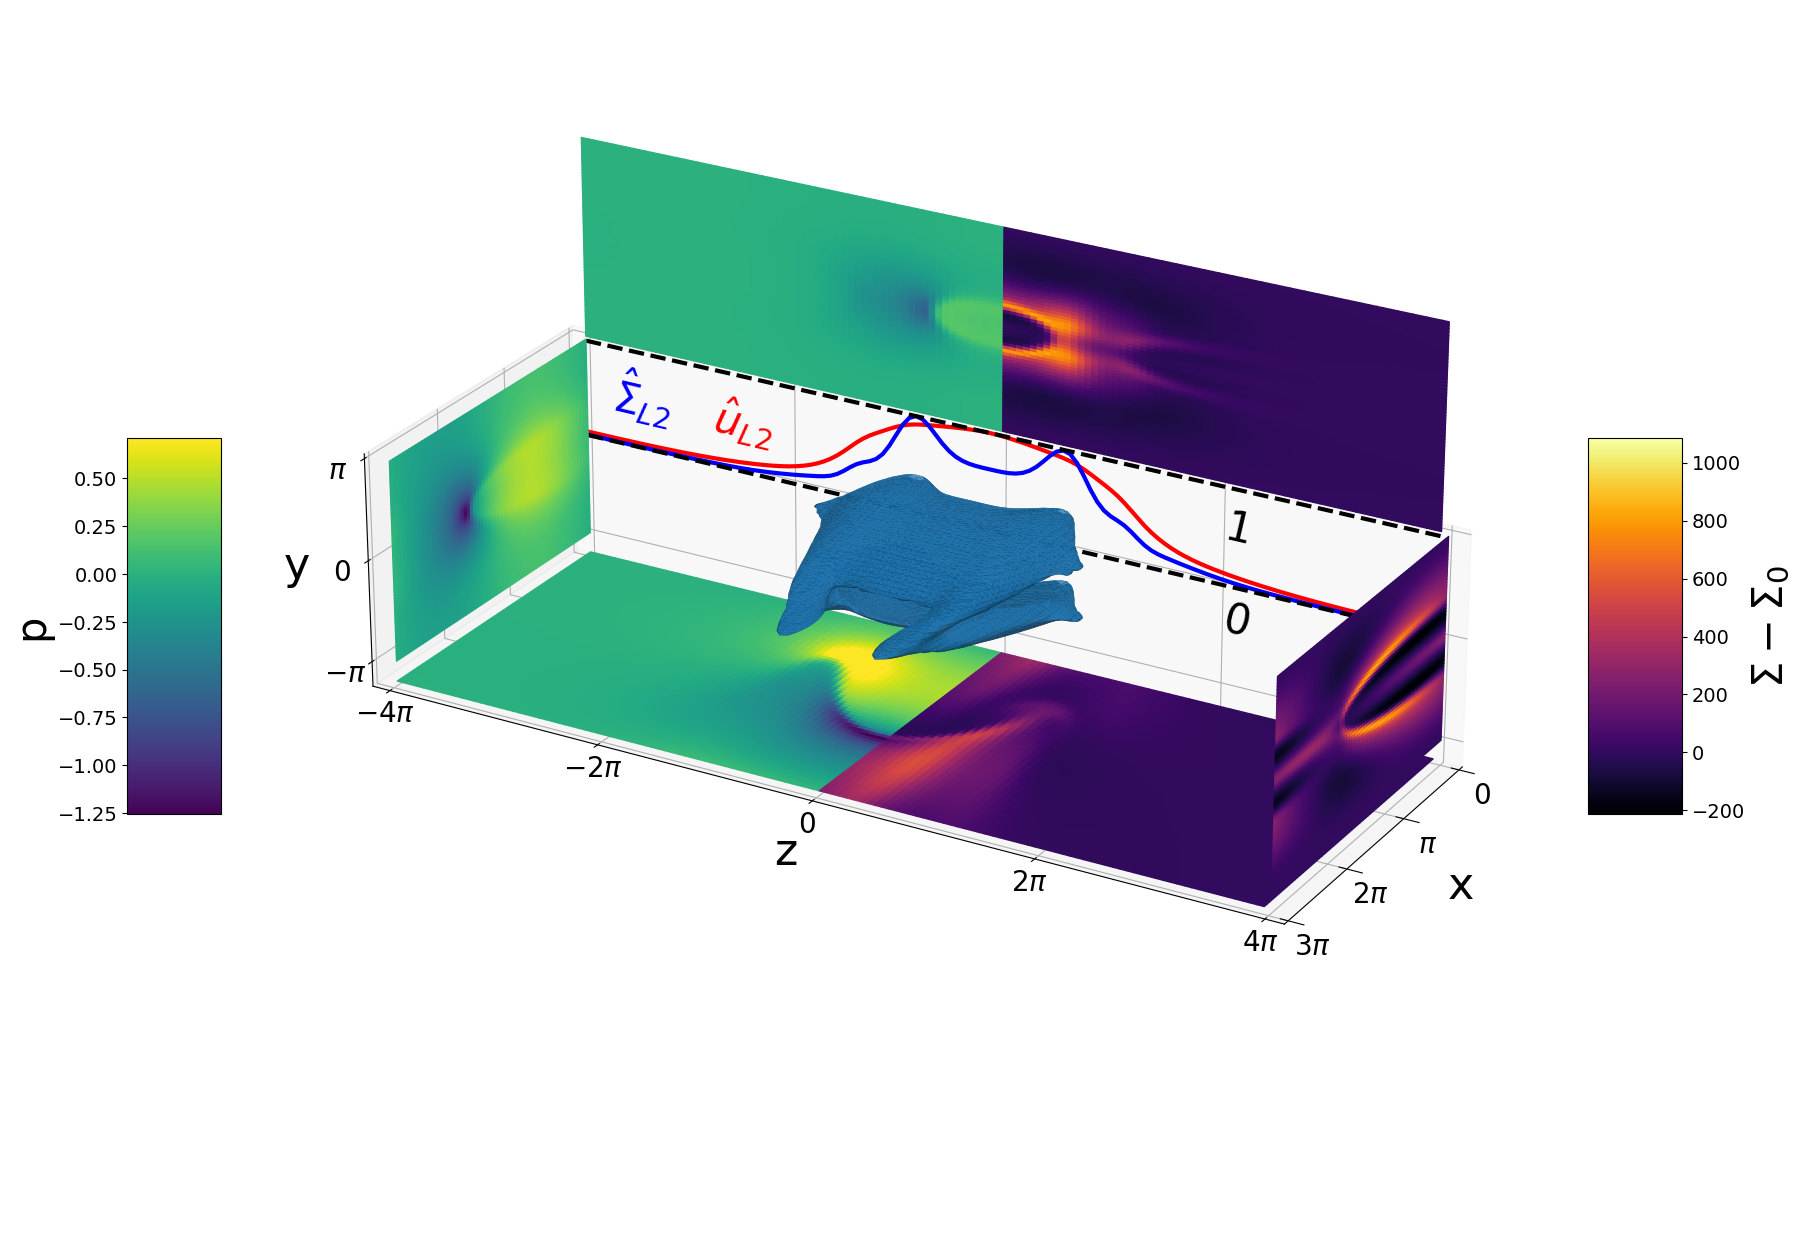

In [ ]:
plt.rcParams['font.size'] = 40

ax, verts, level_val = plot_3D_surface(trace, x, y, z, ax=None, level_mult=0.41, zorder=0.2, level_val=450)
# ax, verts, level_val = plot_3D_surface(p, x, y, z, ax=ax, level_mult=[0.9,0.1], zorder=0.2)

ax.view_init(elev=25, azim=30, roll=0)

ax.computed_zorder = False

ax.set_box_aspect((np.max(x)-np.min(x), np.max(z)-np.min(z), np.max(y)-np.min(y)), zoom=0.9)
ax.set_xlim(0, 3*np.pi)  
ax.set_ylim(-4*np.pi, 4*np.pi)  

ax.set_zlim((-1.2*np.pi, np.pi))

ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$'], fontsize=20)
ax.set_zticks([-np.pi, 0, np.pi, ], [r'$-\pi$', '0', r'$\pi$'], fontsize=20)
ax.set_yticks([0, 2*np.pi, 4*np.pi, -2*np.pi, -4*np.pi], ['0', r'$2\pi$', r'$4\pi$', r'$-2\pi$', r'$-4\pi$'], fontsize=20)
    
### Get key p, trace terms
min_p, max_p = np.min(p), np.max(p) * 0.6
min_tr, max_tr = np.min(trace), np.max(trace)

cmap_kind_p = 'viridis'
cmap_p = plt.get_cmap(cmap_kind_p)
cmap_kind_tr = 'inferno'
cmap_tr = plt.get_cmap(cmap_kind_tr)

norm_p = Normalize(vmin=min_p, vmax=max_p)
sm_p = plt.cm.ScalarMappable(cmap=cmap_kind_p, norm=norm_p)
norm_tr = Normalize(vmin=min_tr, vmax=max_tr)
sm_tr = plt.cm.ScalarMappable(cmap=cmap_kind_tr, norm=norm_tr)

### Get x-z plane

xgrid, zgrid = np.meshgrid(x, z, sparse=False, indexing='ij')

p_plane = p[:,:,Ny//2]
tr_plane = trace[:,:,Ny//2]

p_plane, xgrid_p, zgrid_p = p_plane[:,:Nz//2+1], xgrid[:, :Nz//2+1], zgrid[:,:Nz//2+1]
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))
tr_plane, xgrid_tr, zgrid_tr = tr_plane[:,Nz//2:], xgrid[:, Nz//2:], zgrid[:,Nz//2:]
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(xgrid_p, zgrid_p, -1.2*np.pi * np.ones_like(xgrid_p), rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.1)
ax.plot_surface(xgrid_tr, zgrid_tr, -1.2*np.pi * np.ones_like(xgrid_tr), rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=0.1)

### Get x-y plane

xgrid, ygrid = np.meshgrid(x, y, sparse=False, indexing='ij')

p_plane = p[:,Nz//2,:]
tr_plane = trace[:,Nz//2,:]

p_plane, xgrid_p, ygrid_p = p_plane, xgrid, ygrid
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))
tr_plane, xgrid_tr, ygrid_tr = tr_plane, xgrid, ygrid
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(xgrid_p, -4*np.pi * np.ones_like(xgrid_p), ygrid_p, rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.1)
ax.plot_surface(xgrid_tr, 4*np.pi * np.ones_like(xgrid_tr), ygrid_tr, rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=0.1)


### Get y-z plane

zgrid, ygrid = np.meshgrid(z, y, sparse=False, indexing='ij')

p_plane = p[Nx//2,:,:]
tr_plane = trace[Nx//2,:,:]

p_plane, zgrid_p, ygrid_p = p_plane[:Nz//2+1,:], zgrid[:Nz//2+1,:], ygrid[:Nz//2+1,:]
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))

tr_plane, zgrid_tr, ygrid_tr = tr_plane[Nz//2:,:], zgrid[Nz//2:,:], ygrid[Nz//2:,:]
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(np.zeros_like(zgrid_p), zgrid_p, ygrid_p+2*np.pi, rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.01)
ax.plot_surface(np.zeros_like(zgrid_tr), zgrid_tr, ygrid_tr +2*np.pi, rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=0.01)


sm_p.set_array([])  # Necessary for ScalarMappable to work with colorbar
cbar = plt.colorbar(sm_p, ax=ax, shrink=0.2, aspect=4, location='left', pad=0.03)
cbar.set_label(label='p', size=30)

sm_tr.set_array([])  # Necessary for ScalarMappable to work with colorbar
cbar = plt.colorbar(sm_tr, ax=ax, shrink=0.2, aspect=4, location='right')
cbar.set_label(label=r'$\Sigma - \Sigma_0$', size=30)

### Showing max trace, u over z
color = 'red'
u_metric = get_activity(u, x, y)
u_metric = u_metric / np.max(u_metric)
ax.plot(z, u_metric*3, zs=0, zdir='x', color='red', zorder=0.01, linewidth=3)
trace_metric = get_activity(trace, x, y)
trace_metric = trace_metric / np.max(trace_metric)
ax.plot(z, trace_metric*3, zs=0, zdir='x', color='blue', zorder=0.01, linewidth=3)
ax.plot(z, 0 * np.ones_like(z), zs=0, zdir='x', color='black', linestyle='--', zorder=0.01, linewidth=3)
ax.plot(z, 3 * np.ones_like(z), zs=0, zdir='x', color='black', linestyle='--', zorder=0.01, linewidth=3)

ax.text(0,-2.8*np.pi, 0.6, r'$\hat u_{L2}$', 'y', color='red', fontsize=30)
ax.text(0,-3.8*np.pi, 0.5, r'$\hat \Sigma_{L2}$', 'y', color='blue', fontsize=30)
ax.text(0,2*np.pi, -0.5 *np.pi, r'$0$','y',  color='black', fontsize=30)
ax.text(0,2*np.pi, 0.4*np.pi, r'$1$', 'y', color='black', fontsize=30)


In [33]:

# def set_ticks(x=True, z=True):
#     if x:
#         plt.xticks([0,  np.max(xx)], ['0', r'$3\pi$'], fontsize=20)
#         plt.xlabel('x', fontsize=22)
#     else:
#         plt.xticks([])
#     if z:
#         plt.yticks([0, 2*np.pi, np.max(zz), -2*np.pi, np.min(zz)], ['0', r'$2\pi$', r'$4\pi$', r'$-2\pi$', r'$-4\pi$'], fontsize=20)
#         plt.ylabel('z', fontsize=22)
#     else:
#         plt.yticks([])


# xx, zz = np.meshgrid(x, z, indexing='ij', sparse=False)

# cmap_kind = 'viridis'

# plt.subplots(2,2, figsize=(10,16))

# ax = plt.subplot(2,2,1)
# plt.pcolormesh(xx, zz, c11[:,:,Ny//2], cmap=cmap_kind, shading='gouraud',)
# set_ticks(x=False, z=True)
# ax.set_aspect(1)
# plt.colorbar(location='right', ticks=[0,250,500])
# ax = plt.subplot(2,2,2)
# plt.pcolormesh(xx, zz, u[:,:,Ny//2], cmap=cmap_kind, shading='gouraud',)
# set_ticks(x=False, z=False)
# ax.set_aspect(1)
# plt.colorbar(location='right', ticks=[-0.15, -0.1, -0.05, 0, 0.1])
# ax = plt.subplot(2,2,3)
# plt.pcolormesh(xx, zz, c22[:,:,Ny//2], cmap=cmap_kind, shading='gouraud',)
# set_ticks(x=True, z=True)
# ax.set_aspect(1)
# plt.colorbar(location='right')
# ax = plt.subplot(2,2,4)
# plt.pcolormesh(xx, zz, p[:,:,Ny//2], cmap=cmap_kind, shading='gouraud',)
# set_ticks(x=True, z=False)
# ax.set_aspect(1)
# plt.colorbar(location='right')
# plt.tight_layout()
# # min_val, max_val = np.min(field), np.max(field)


# Streamwise Localisation

In [39]:
from tools.kolmogorov import TimeStepper3D

material_params = {'W': 20, 'beta': 0.9, 'Re': 0.5, 'L':np.infty, 'eps': 1e-3}
system_params = {'Lx': 38*np.pi, 'ndim': 2, 'n':1}
solver_params = {'Nx': 450, 'Ny': 64}

Nx = solver_params['Nx']
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params)
base_flow = timestepper.base_flow_full

suffix_end = f'recent-'

data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix=suffix_end, subdir='arrowhead_2D', s=-1)

x1, y = data_fields['x'], data_fields['y']
trace = data_fields['c11'][-1,:,:] + data_fields['c22'][-1,:,:] + data_fields['c33'][-1,:,:]
trace_dev1 = trace - base_flow['c11'][:,:] - base_flow['c22'][:,:] - base_flow['c33'][:,:]

2025-03-11 22:50:40,461 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


In [ ]:
from tools.kolmogorov import TimeStepper3D

material_params = {'W': 20, 'beta': 0.9, 'Re': 0.5, 'L':np.infty, 'eps': 1e-3}
system_params = {'Lx': 35*np.pi, 'ndim': 2, 'n':1}
solver_params = {'Nx': 450, 'Ny': 64}

Nx = solver_params['Nx']
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params)
base_flow = timestepper.base_flow_full

suffix_end = f'recent-'

data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix=suffix_end, subdir='arrowhead_2D', s=-1)

x, y = data_fields['x'], data_fields['y']
trace = data_fields['c11'][-1,:,:] + data_fields['c22'][-1,:,:] + data_fields['c33'][-1,:,:]
trace_dev = trace - base_flow['c11'][:,:] - base_flow['c22'][:,:] - base_flow['c33'][:,:]

2025-03-11 22:50:48,701 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


0.04539601167503083
0.06011779695443218


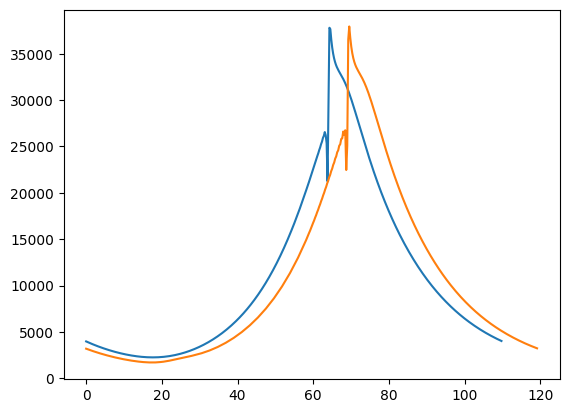

In [44]:
trace_metric = np.linalg.norm(trace_dev, axis=1)
trace_metric1 = np.linalg.norm(trace_dev1, axis=1)
plt.plot(x, trace_metric)
plt.plot(x1, trace_metric1)
print(np.min(trace_metric1/np.max(trace_metric1)))
print(np.min(trace_metric/np.max(trace_metric)))

# Energy Analysis

In [12]:
from tools.kolmogorov import TimeStepper3D
import copy 

material_params = {'W': 20, 'beta': 0.9, 'Re': 0.5, 'L':np.infty, 'eps': 1e-3}
system_params = {'Lx': 3*np.pi,  'Lz': 8*np.pi, 'ndim': 3, 'n':1}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}

beta = material_params['beta']
Re = material_params['Re']
W = material_params['W']

Nz, Nx = solver_params['Nz'], solver_params['Nx']
system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

suffix_end = f'recent-a-{np.pi/2:.4g}-b-{np.pi/4:.4g}-Lz-orig-3,14'

data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix=suffix_end, subdir='windows', s=-1)

x, y, z = data_fields['x'], data_fields['y'], data_fields['z']


2025-03-14 10:02:51,376 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


In [38]:
U = base_flow['u']
C11 = base_flow['c11'] 
C22 = base_flow['c22']
C33 = base_flow['c33']

u = data_fields['u'][-1,:,:,:]
v = data_fields['v'][-1,:,:,:]
w = data_fields['w'][-1,:,:,:]
c11 = data_fields['c11'][-1,:,:,:]
c22 = data_fields['c22'][-1,:,:,:]
c33 = data_fields['c33'][-1,:,:,:]
c12 = data_fields['c12'][-1,:,:,:]
c13 = data_fields['c13'][-1,:,:,:]
c23 = data_fields['c23'][-1,:,:,:]

u_prime = u - base_flow['u'][:, None, :]
v_prime = v 
w_prime = w 
c11_prime = c11  - base_flow['c11'][:, None, :]
c22_prime = c22  - base_flow['c22'][:, None, :]
c33_prime = c33  - base_flow['c33'][:, None, :]
c12_prime = c12 - base_flow['c12'][:, None, :]
c23_prime = c23 
c13_prime = c13 




In [39]:
from scipy.integrate import trapezoid

def vol_average_rough(field, x, y, z):
    field_x = trapezoid(field, x, axis=0) / (np.max(x) - np.min(x))
    field_xy = trapezoid(field_x, y, axis=-1) / (np.max(y) - np.min(y))
    field_xyz = trapezoid(field_xy, z, axis=-1) / (np.max(z) - np.min(z))
    return field_xyz

In [40]:
dx = lambda f: np.gradient(f, x, axis=0) 
dy = lambda f: np.gradient(f, y, axis=2) 
dz = lambda f: np.gradient(f, z, axis=1) 

In [ ]:
diss_elast_xx = - (1 - beta) / Re / W * vol_average_rough(c11_prime*dx(u_prime), x, y, z) ###
diss_elast_xy = - (1 - beta) / Re / W * vol_average_rough(c12_prime*dx(v_prime) + c12_prime*dy(u_prime), x, y, z)
diss_elast_xz = - (1 - beta) / Re / W * vol_average_rough(c22_prime*dy(v_prime), x, y, z)
diss_elast_yy = - (1 - beta) / Re / W * vol_average_rough(c13_prime*dx(w_prime) + c13_prime*dz(u_prime), x, y, z)
diss_elast_yz = - (1 - beta) / Re / W * vol_average_rough(c33_prime*dz(w_prime), x, y, z)
diss_elast_zz = - (1 - beta) / Re / W * vol_average_rough(c23_prime*dy(w_prime) + c23_prime*dz(v_prime), x, y, z)

print(diss_elast_xx, diss_elast_xy, diss_elast_xz, diss_elast_yy)

0.005414711961702589 0.0008425586040332234 -0.0004140131626171205 0.0007085003322934586


In [48]:
diss_visc_xx = - beta / Re * vol_average_rough(dx(u_prime) ** 2, x, y , z)
diss_visc_yy = - beta / Re * vol_average_rough(dy(v_prime) ** 2, x, y , z)
diss_visc_zz = - beta / Re * vol_average_rough(dz(w_prime) ** 2, x, y , z)
diss_visc_xy = - beta / Re * vol_average_rough(dx(v_prime) ** 2, x, y , z)
diss_visc_xz = - beta / Re * vol_average_rough(dx(w_prime) ** 2, x, y , z)
diss_visc_yz = - beta / Re * vol_average_rough(dy(w_prime) ** 2, x, y , z)
diss_visc_yx = - beta / Re * vol_average_rough(dy(u_prime) ** 2, x, y , z)  ####
diss_visc_zx = - beta / Re * vol_average_rough(dz(u_prime) ** 2, x, y , z)
diss_visc_zy = - beta / Re * vol_average_rough(dz(v_prime) ** 2, x, y , z)

print(diss_visc_xx, diss_visc_yy, diss_visc_yx, diss_visc_zx)

-0.00045170254836582205 -0.00043852142154307013 -0.004329323890804437 -0.0004804461952305621


In [50]:
visc = diss_visc_xx + diss_visc_yy + diss_visc_zz + diss_visc_xy + diss_visc_xz + diss_visc_yz + diss_visc_yx + diss_visc_zx + diss_visc_zy
elast = diss_elast_xx + diss_elast_yy + diss_elast_zz + diss_elast_xy + diss_elast_xz + diss_elast_yz
diss = visc + elast
print(diss)

0.0003823571293450935


# How Subcritical is the AH

In [14]:
from tools.misc_tools import get_AH_W_list

W_list_2D = get_AH_W_list(eps=1e-3, beta=0.9, Re=0.5, L=np.infty, Lx=3*np.pi, Nx=128, Ny=256, ndim=2, Nz=None, Lz=None, subdir='arrowhead_2D', suffix='recent-')
# W_list_3D = get_AH_W_list(eps=1e-3, beta=0.9, Re=0.5, L=np.infty, Lx=3*np.pi, Nx=64, Ny=64, ndim=3, Nz=128, Lz=8*np.pi, subdir='arrowhead_3D', suffix='recent-localised')

W_list_3D = [17,18,19,20]

In [15]:
from tools.misc_tools import get_metric_from_params

material_params = {'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 128, 'Ny': 256,}
system_params = {'Lx': 3*np.pi,  'ndim': 2, 'n': 1}

metric_list_2D = []
W_list_2D_plot = []
for W in reversed(W_list_2D):
    material_params['W'] = W
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-', subdir='arrowhead_2D', metric='trace', deviation=True)
    metric_list_2D.append(metric_all[-1])
    W_list_2D_plot.append(W)


material_params = {'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1, 'Lz': 8*np.pi}

metric_list_3D = []
W_list_3D_plot = []
for W in reversed(W_list_3D):
    material_params['W'] = W
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-localised', subdir='arrowhead_3D', metric='trace', deviation=True)
    metric_list_3D.append(metric_all[-1])
    W_list_3D_plot.append(W)



In [16]:
material_params['W'] = 20
data_fields, data_metric = get_h5_data(material_params, system_params, solver_params, suffix='recent-localised', subdir='arrowhead_3D', s=-1)

[0.09459101838274936, 0.09024380908558545, 0.07779460043171338, 0.05485459070280099]
[20, 19, 18, 17]


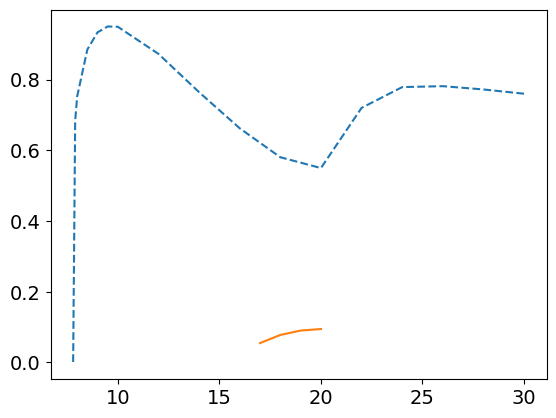

In [17]:
plt.plot(W_list_2D_plot, metric_list_2D, linestyle='--')
plt.plot(W_list_3D_plot, metric_list_3D, linestyle='-')
print(metric_list_3D)
print(W_list_3D_plot)

# Lz Bifurcation Plot

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid

from tools.misc_tools import get_h5_data
from matplotlib.colors import Normalize, LightSource
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from scipy.interpolate import CubicSpline

def spline(Lz, metric):
    cs = CubicSpline(Lz, metric)
    Lz_high = np.linspace(np.min(Lz), np.max(Lz), 1000)
    metric_high = cs(Lz_high)
    return Lz_high, metric_high

In [4]:
def get_mean_max_min(t, metric_all, t_cutoff=500):

    metric_trunc = metric_all[t[-1] - t < t_cutoff]
    return np.mean(metric_trunc), np.max(metric_trunc), np.min(metric_trunc)

In [5]:
import h5py
from tools.kolmogorov import TimeStepper3D
import copy 

def get_edge_metric(fpath=None):

    h5 = h5py.File(fpath, 'r')

    tasks = h5['tasks']
    scales = h5['scales']

    tr = tasks['vol_tr'][:][0,0,0] 
    Tr = tasks['vol_Tr'][:][0,0,0] 

    return (tr - Tr) / Tr

3.330088212805181
3.9269908169872414
4.39822971502571
5.026548245743669
5.654866776461628
6.283185307179586
7.853981633974483
9.42477796076938
10.995574287564276
11.938052083641214
12.566370614359172
12.88052987971815
13.194689145077131
13.50884841043611
13.823007675795091
3.141592653589793
2.827433388230814
2.796017461694916
[0.23355839] [0.24701529] [0.24184752] [0.25058418]


(0.0, 25.132741228718345)

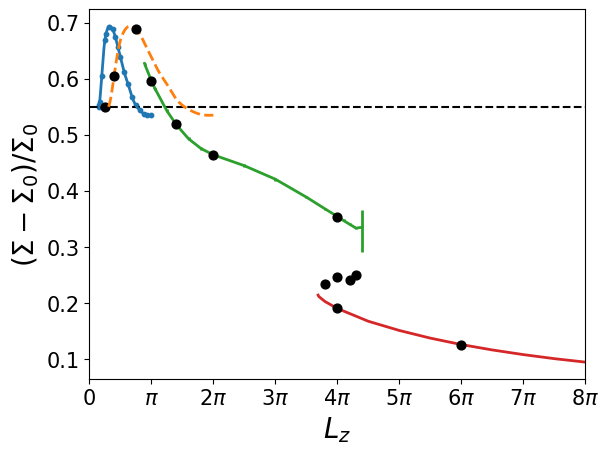

In [6]:
from tools.misc_tools import get_metric_from_params

plt.Figure(figsize=(12,12))
mode = 'trace'

material_params = {'W':20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1, 'Lz': 8*np.pi}

# 2D AH
metric_list = []
Lz_list_plot = [np.pi/8]
Nz_list = [16]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-periodic', subdir='arrowhead_3D', metric=mode, deviation=True)
    metric_list.append(metric_all[-1])
plt.hlines(metric_list[0], 0, 0.4712, color='k', linewidth=1.5)
plt.hlines(metric_list[0], 0.4712, 8*np.pi, color='k', linewidth=1.5, linestyle='--')
plt.scatter([Lz_list_plot[0]*2], [metric_list[0]], color='black', s=40, zorder=2)

# m=1 mode
metric_list = []
Lz_list_plot = np.array([ 0.155*np.pi, 0.16*np.pi, np.pi/6, np.pi/5, np.pi/4, 0.27*np.pi, 5*np.pi/16,6*np.pi/16, 0.42*np.pi, 0.46*np.pi, np.pi/2,  9*np.pi/16,10*np.pi/16,11*np.pi/16, 12*np.pi/16,13*np.pi/16,14*np.pi/16, 15*np.pi/16, np.pi])
Nz_list =               [  16,    16, 16, 16,     16,    16,    16,        16,    16,        16,        16,        16,     16, 16,   16,            16,        16,        16,            32]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
    metric_list.append(metric_all[-1])
Lz_list_high_res_plot, metric_high_res_list = spline(Lz_list_plot, metric_list)
plt.plot(Lz_list_high_res_plot, metric_high_res_list, color='tab:blue', linewidth=2)
plt.scatter(Lz_list_plot, metric_list, color='tab:blue', s=10)

# m=2 mode from m=1
# plt.plot(Lz_list_plot*2, metric_list, color='tab:orange')
plt.plot(Lz_list_high_res_plot*2, metric_high_res_list, color='tab:orange', linestyle='--', linewidth=2)
plt.scatter([Lz_list_plot[3]*2, Lz_list_plot[7]*2], [metric_list[3], metric_list[7]], color='black', s=40, zorder=2)

# m=2
metric_list = []
max_list = []
min_list = []

Lz_list_plot = np.array([ 1.06*np.pi, 1.25*np.pi, 1.4*np.pi, 1.6*np.pi, 1.8*np.pi,  2*np.pi, 2.5*np.pi, 3*np.pi, 3.5*np.pi, 3.8*np.pi, 4*np.pi, 4.1*np.pi, 4.2*np.pi, 4.3*np.pi, 4.4*np.pi])
Nz_list =               [    32,         32,         32,        32,          32    ,  64,         64,         64,          64,  64,    64,  96, 96, 96, 96, 96, 96, 96]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    print(Lz)
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='long-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
    metric_mean, metric_max, metric_min = get_mean_max_min(t_all, metric_all)
    metric_list.append(metric_mean)
    max_list.append(metric_max-metric_mean)
    min_list.append(metric_mean-metric_min)
errors = np.concatenate((np.array([min_list]), np.array([max_list])), axis=0)
plt.errorbar(Lz_list_plot, metric_list, yerr=errors, color='tab:green', linewidth=2)
plt.scatter([Lz_list_plot[2], Lz_list_plot[5], Lz_list_plot[-5]], [metric_list[2], metric_list[5], metric_list[-5]], color='black', s=40, zorder=3)

# continuing mode backwards
metric_list = []
max_list = []
min_list = []
Lz_list_plot = np.array([np.pi, 0.9*np.pi, 0.89*np.pi])
Nz_list =               [ 32,     32,        32,  32, 32  , 32, 32]

for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    print(Lz)
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='long-below-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
    metric_mean, metric_max, metric_min = get_mean_max_min(t_all, metric_all)
    metric_list.append(metric_mean)
    max_list.append(metric_max-metric_mean)
    min_list.append(metric_mean-metric_min)

system_params['Lz'] = 1.06*np.pi
solver_params['Nz'] = 32
t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='long-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
metric_mean, metric_max, metric_min = get_mean_max_min(t_all, metric_all)

errors = np.concatenate((np.array([min_list]), np.array([max_list])), axis=0)

# plt.scatter(Lz_list_plot, metric_list, color='tab:green')

Lz_list_plot = np.concatenate(([1.06*np.pi], Lz_list_plot ))
metric_list = np.concatenate(([metric_mean], metric_list ))
extra_error = np.array([[metric_mean-metric_min, metric_max - metric_mean]])
errors = np.concatenate((extra_error.T, errors), axis=1)
plt.errorbar(Lz_list_plot, metric_list, yerr=errors, color='tab:green', capthick=True, linewidth=2)
plt.scatter([Lz_list_plot[1]], [metric_list[1]], color='black', s=40, zorder=3)

# Continuing to the period doubling bifurcation

# metric_list = []
# max_list = []
# min_list = []
# Lz_list_plot = np.array([0.89*np.pi, 0.85*np.pi, 0.84*np.pi, 0.83*np.pi])
# Nz_list =               [ 32,     32,        32,  32, 32  , 32, 32]

# for Lz, Nz in zip(Lz_list_plot, Nz_list):
#     system_params['Lz'] = Lz
#     solver_params['Nz'] = Nz
#     t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='long-below-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
#     metric_mean, metric_max, metric_min = get_mean_max_min(t_all, metric_all)
#     metric_list.append(metric_mean)
#     max_list.append(metric_max-metric_mean)
#     min_list.append(metric_mean-metric_min)

# errors = np.concatenate((np.array([min_list]), np.array([max_list])), axis=0)

# plt.errorbar(Lz_list_plot, metric_list, yerr=errors, color='tab:green', capthick=True)



# localised mode
metric_list = []

Lz_list_plot = [8*np.pi, 7.5*np.pi, 7*np.pi, 6.5*np.pi, 6*np.pi, 5.5*np.pi, 5*np.pi, 4.5*np.pi, 4*np.pi, 3.8*np.pi, 3.75*np.pi, 3.7*np.pi, 3.69*np.pi]
Nz_list =      [128,     120,       112,     104,       96,      88,        80,      72,        64,      64,     64,     64, 64, 64]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-localised', subdir='arrowhead_3D', metric=mode, deviation=True)
    if len(metric_all) == 0:
        t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-localised-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
    metric_list.append(metric_all[-1])
plt.plot(Lz_list_plot, metric_list, color='tab:red', linewidth=2, zorder=1)
plt.scatter([Lz_list_plot[4], Lz_list_plot[-5]], [metric_list[4], metric_list[-5]], color='black', s=40, zorder=2)

# edge states
metric_3_8pi = get_edge_metric(fpath="/nfs/st01/hpc-fluids-rrk26/tal43/vKolmogorov3D/edge_track/edge_states/Lz_3,8pi.h5")
metric_4pi = get_edge_metric(fpath="/nfs/st01/hpc-fluids-rrk26/tal43/vKolmogorov3D/edge_track/edge_states/Lz_4pi.h5")
metric_4_2pi = get_edge_metric(fpath="/nfs/st01/hpc-fluids-rrk26/tal43/vKolmogorov3D/edge_track/edge_states/Lz_4,2pi.h5")
metric_4_3pi = get_edge_metric(fpath="/nfs/st01/hpc-fluids-rrk26/tal43/vKolmogorov3D/edge_track/edge_states/Lz_4,3pi.h5")

print(metric_3_8pi, metric_4pi, metric_4_2pi, metric_4_3pi)
plt.scatter([3.8*np.pi, 4*np.pi, 4.2*np.pi, 4.3*np.pi], [metric_3_8pi, metric_4pi, metric_4_2pi, metric_4_3pi], color='black', s=40, zorder=2)

plt.xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi, 6*np.pi, 7*np.pi, 8*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$', r'$5\pi$', r'$6\pi$',  r'$7\pi$', r'$8\pi$'], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$L_z$', fontsize=20)
plt.ylabel(r'$(\Sigma-\Sigma_0)/\Sigma_0$', fontsize=20)

plt.xlim(0,8*np.pi)


0.25
0.4 0.75
3.330088212805181
3.9269908169872414
4.39822971502571
5.026548245743669
5.654866776461628
6.283185307179586
7.853981633974483
9.42477796076938
10.995574287564276
11.938052083641214
12.566370614359172
12.88052987971815
13.194689145077131
13.50884841043611
13.823007675795091
6.283185307179586 12.566370614359172
3.141592653589793
2.827433388230814
2.796017461694916


(0.48, 0.72)

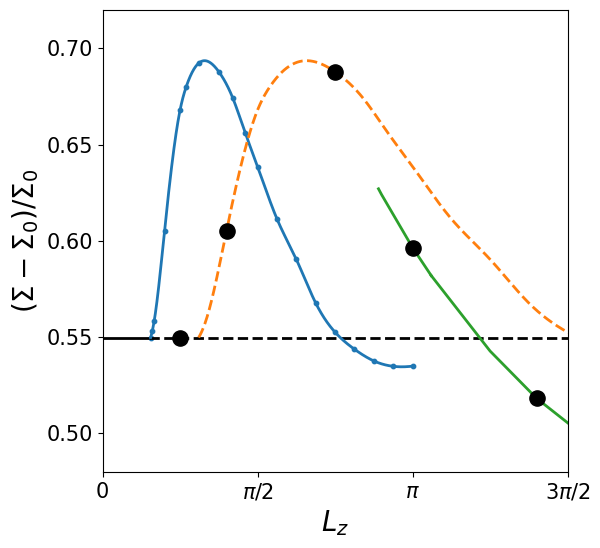

In [7]:
from tools.misc_tools import get_metric_from_params

plt.figure(figsize=(6, 6))
mode = 'trace'

material_params = {'W':20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1, 'Lz': 8*np.pi}

# 2D AH
metric_list = []
Lz_list_plot = [np.pi/8]
Nz_list = [16]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-periodic', subdir='arrowhead_3D', metric=mode, deviation=True)
    metric_list.append(metric_all[-1])
plt.hlines(metric_list[0], 0, 0.4712, color='k', linewidth=2)
plt.hlines(metric_list[0], 0.4712, 1.5*np.pi, color='k', linewidth=2, linestyle='--')
plt.scatter([Lz_list_plot[0]*2], [metric_list[0]], color='black', s=120, zorder=2)
print(Lz_list_plot[0]*2/np.pi)

# m=1 mode
metric_list = []
Lz_list_plot = np.array([ 0.155*np.pi, 0.16*np.pi, np.pi/6, np.pi/5, np.pi/4, 0.27*np.pi, 5*np.pi/16,6*np.pi/16, 0.42*np.pi, 0.46*np.pi, np.pi/2,  9*np.pi/16,10*np.pi/16,11*np.pi/16, 12*np.pi/16,13*np.pi/16,14*np.pi/16, 15*np.pi/16, np.pi])
Nz_list =               [  16,    16, 16, 16,     16,    16,    16,        16,    16,        16,        16,        16,     16, 16,   16,            16,        16,        16,            32]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
    metric_list.append(metric_all[-1])

Lz_list_high_res_plot, metric_high_res_list = spline(Lz_list_plot, metric_list)
plt.plot(Lz_list_high_res_plot, metric_high_res_list, color='tab:blue', linewidth=2)
plt.scatter(Lz_list_plot, metric_list, color='tab:blue', s=10)

# m=2 mode from m=1
# plt.plot(Lz_list_plot*2, metric_list, color='tab:orange')
plt.plot(Lz_list_high_res_plot*2, metric_high_res_list, color='tab:orange', linestyle='--', linewidth=2)
plt.scatter([Lz_list_plot[3]*2, Lz_list_plot[7]*2], [metric_list[3], metric_list[7]], color='black', s=120, zorder=2)
print(Lz_list_plot[3]*2/np.pi, Lz_list_plot[7]*2/np.pi)


# m=2
metric_list = []
max_list = []
min_list = []

Lz_list_plot = np.array([ 1.06*np.pi, 1.25*np.pi, 1.4*np.pi, 1.6*np.pi, 1.8*np.pi,  2*np.pi, 2.5*np.pi, 3*np.pi, 3.5*np.pi, 3.8*np.pi, 4*np.pi, 4.1*np.pi, 4.2*np.pi, 4.3*np.pi, 4.4*np.pi])
Nz_list =               [    32,         32,         32,        32,          32    ,  64,         64,         64,          64,  64,    64,  96, 96, 96, 96, 96, 96, 96]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    print(Lz)
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='long-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
    metric_mean, metric_max, metric_min = get_mean_max_min(t_all, metric_all)
    metric_list.append(metric_mean)
    max_list.append(metric_max-metric_mean)
    min_list.append(metric_mean-metric_min)
errors = np.concatenate((np.array([min_list]), np.array([max_list])), axis=0)
plt.plot(Lz_list_plot, metric_list, color='tab:green', linewidth=2)
plt.scatter([Lz_list_plot[2], Lz_list_plot[5], Lz_list_plot[-5]], [metric_list[2], metric_list[5], metric_list[-5]], color='black', s=120, zorder=3)
print(Lz_list_plot[5], Lz_list_plot[-5])

# continuing mode backwards
metric_list = []
max_list = []
min_list = []
Lz_list_plot = np.array([np.pi, 0.9*np.pi, 0.89*np.pi])
Nz_list =               [ 32,     32,        32,  32, 32  , 32, 32]

for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    print(Lz)
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='long-below-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
    metric_mean, metric_max, metric_min = get_mean_max_min(t_all, metric_all)
    metric_list.append(metric_mean)
    max_list.append(metric_max-metric_mean)
    min_list.append(metric_mean-metric_min)

system_params['Lz'] = 1.06*np.pi
solver_params['Nz'] = 32
t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='long-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
metric_mean, metric_max, metric_min = get_mean_max_min(t_all, metric_all)

errors = np.concatenate((np.array([min_list]), np.array([max_list])), axis=0)

# plt.scatter(Lz_list_plot, metric_list, color='tab:green')

Lz_list_plot = np.concatenate(([1.06*np.pi], Lz_list_plot ))
metric_list = np.concatenate(([metric_mean], metric_list ))
extra_error = np.array([[metric_mean-metric_min, metric_max - metric_mean]])
errors = np.concatenate((extra_error.T, errors), axis=1)
plt.plot(Lz_list_plot, metric_list, color='tab:green', linewidth=2)
plt.scatter([Lz_list_plot[1]], [metric_list[1]], color='black', s=120, zorder=3)


plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$'], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$L_z$', fontsize=20)
plt.ylabel(r'$(\Sigma-\Sigma_0)/\Sigma_0$', fontsize=20)
plt.xlim(0, 1.5*np.pi)
plt.ylim(0.48, 0.72)


In [8]:
from tools.kolmogorov import TimeStepper3D
from tools.misc_tools import get_h5_data_from_fpath
import h5py
import copy 

def standardise(activity, shift=None):
    Nz = activity.shape[0]
    if np.argmax(activity) <= Nz // 4 or np.argmax(activity) >= 3*Nz // 4:
        activity = np.roll(activity, shift=Nz//2)
    if shift is not None:
        activity = np.roll(activity, shift=shift)

    return activity

def tile(activity, z, Lz):
    nZ = z.shape[0]
    activity = np.concatenate((activity, activity))
    z = np.concatenate((z - Lz, z, z + Lz))[nZ//2:-nZ//2]    
    return activity, z

def get_activity(field, x, y):
    field_2  = np.array(field) ** 2 
    field_2_x = trapezoid(field_2, x, axis=-3) / (3*np.pi)
    field_2_xy = trapezoid(field_2_x, y, axis=-1) / (2*np.pi)
    field_xy = field_2_xy ** 0.5
    return field_xy

def get_activity_from_Lz(base_flow, material_params, system_params, solver_params, Lz, Nz, suffix, fpath=None):
    
    if fpath is None:
        system_params['Lz'] = Lz
        solver_params['Nz'] = Nz
        data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix, subdir='arrowhead_3D', s=-1)
    else:

        h5 = h5py.File(fpath, 'r')

        tasks = h5['tasks']
        scales = h5['scales']

        data_fields = {}

        for field_name in ['c11', 'c22', 'c33']:
            data_fields[field_name] = tasks[field_name][:]
        for coord in ['x', 'y', 'z']:
            data_fields[coord] = scales[coord]['1.0'][:]

            
    x, y, z = data_fields['x'], data_fields['y'], data_fields['z']
    c11 = data_fields['c11'][-1,:,:,:] - base_flow['c11'][[0], None, :]
    c22 = data_fields['c22'][-1,:,:,:] - base_flow['c22'][[0], None, :]
    c33 = data_fields['c33'][-1,:,:,:] - base_flow['c33'][[0], None, :]
    trace_dev = c11 + c22 + c33
    activity = get_activity(trace_dev, x, y)
    return z, activity

In [9]:
import os
import h5py
from tools.misc_tools import get_fpath_sim

def load_key_fields_from_h5(material_params, system_params, solver_params, suffix='full-periodic-yz', subdir='large_data', s=-1):
    fpath = get_fpath_sim(material_params, system_params, solver_params, suffix=suffix, subdir=subdir)
    if s == -1:
        split_file = sorted([file for file in os.listdir(fpath) if file[-3:] == '.h5'], key=lambda x: int(x.split('_s')[-1][:-3]))[-1]
        h5_fpath = os.path.join(fpath, split_file)
    elif s is None:
        h5_fpath = fpath

    else:
        h5_fpath = os.path.join(fpath, fpath.split('/')[-2] + f"_s{s}.h5")

    h5 = h5py.File(h5_fpath, 'r')
    trace = h5['tasks']['c11'][:]+h5['tasks']['c22'][:]+h5['tasks']['c33'][:]
    x, y, z = h5['scales']['x']['1.0'][:], h5['scales']['y']['1.0'][:], h5['scales']['z']['1.0'][:]
    t = h5['scales']['sim_time'][:]
    trace_metric = h5['tasks']['<trace>'][:][:,0,0,0]
    trace_metric_base = h5['tasks']['<trace_lam>'][:][:,0,0,0]
    trace_metric = (trace_metric - trace_metric_base) / trace_metric_base
    h5.close()

    return x, y, z, trace, t, trace_metric 


2025-09-14 16:39:28,300 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


/tmp/ipykernel_36669/2863459125.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Blues')


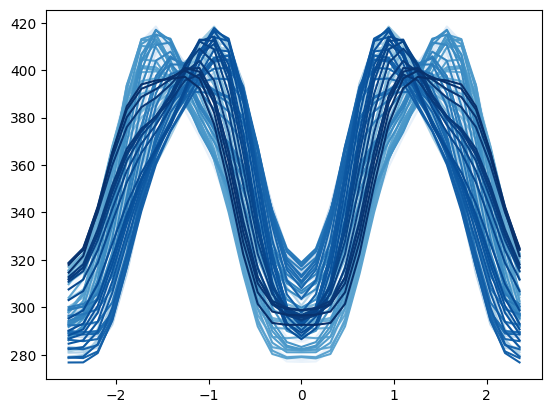

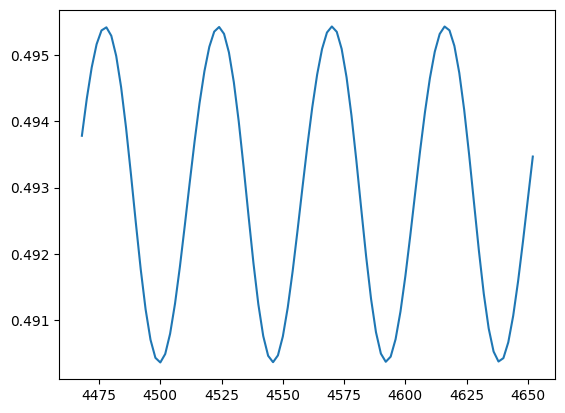

In [10]:
import matplotlib
material_params = {'W':20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 32}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1, 'Lz': 0.9*np.pi}

system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

#########
averaging_dict = {}

# system_params['Lz'] = 0.9*np.pi
# solver_params['Nz'] = 32
# x, y, z, trace, t, trace_metric     = load_key_fields_from_h5(material_params, system_params, solver_params, suffix='full-below-periodic-yz', subdir='large_data', s=-1)
# idx = 53  # does 2 periods

# system_params['Lz'] = 1.4*np.pi
# solver_params['Nz'] = 32
# x, y, z, trace , t, trace_metric = load_key_fields_from_h5(material_params, system_params, solver_params, suffix='full-periodic-yz', subdir='large_data', s=1)
# idx = 91 # does 4 periods

system_params['Lz'] = 1.6*np.pi
solver_params['Nz'] = 32
x, y, z, trace , t, trace_metric = load_key_fields_from_h5(material_params, system_params, solver_params, suffix='full-periodic-yz', subdir='large_data', s=1)
idx = 93 # does 4 periods

# system_params['Lz'] = 2*np.pi
# solver_params['Nz'] = 64
# x, y, z, trace , t, trace_metric    = load_key_fields_from_h5(material_params, system_params, solver_params, suffix='full-periodic-yz', subdir='large_data', s=-1)
# idx = 76  # does 3 periods

# system_params['Lz'] = 2.5*np.pi
# solver_params['Nz'] = 64
# x, y, z, trace , t, trace_metric   = load_key_fields_from_h5(material_params, system_params, solver_params, suffix='full-periodic-yz', subdir='large_data', s=1)
# idx =  84 # does 3 periods

# system_params['Lz'] = 3*np.pi
# solver_params['Nz'] = 64
# x, y, z, trace , t, trace_metric   = load_key_fields_from_h5(material_params, system_params, solver_params, suffix='full-periodic-yz', subdir='large_data', s=1)
# idx = 90  # does 3 periods

# system_params['Lz'] = 3.5*np.pi
# solver_params['Nz'] = 64
# x, y, z, trace , t, trace_metric   = load_key_fields_from_h5(material_params, system_params, solver_params, suffix='full-periodic-yz', subdir='large_data', s=1)
# idx = 64  # does 2 periods

# system_params['Lz'] = 4*np.pi
# solver_params['Nz'] = 64
# x, y, z, trace , t, trace_metric   = load_key_fields_from_h5(material_params, system_params, solver_params, suffix='full-periodic-yz', subdir='large_data', s=-1)
# idx = 69  # does 2 periods


base_trace = base_flow['c11'][None, [0], None, :] + base_flow['c22'][None, [0], None, :] + base_flow['c33'][None, [0], None, :]
trace_dev = trace - base_trace

activity = get_activity(trace_dev, x, y)

# Define a colormap
cmap = matplotlib.cm.get_cmap('Blues')

for i in range(0, idx):
    color = cmap( i / (idx - 1))
    plt.plot(z, activity[-i,:], color=color)

plt.show()
# plt.plot(z, np.mean(activity[-26:,:], axis=0), color='black', linewidth=2)
plt.plot(t[-idx:], trace_metric[-idx:])
plt.show()


In [11]:
def get_average_activity(base_flow, material_params, system_params, solver_params, Lz, Nz, suffix, idx_average_over, s):

    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix, subdir='large_data', s=s)
            
    x, y, z = data_fields['x'], data_fields['y'], data_fields['z']

    c11 = data_fields['c11'][:,:,:,:] - base_flow['c11'][None,[0], None, :]
    c22 = data_fields['c22'][:,:,:,:] - base_flow['c22'][None,[0], None, :]
    c33 = data_fields['c33'][:,:,:,:] - base_flow['c33'][None,[0], None, :]

    trace_dev = c11 + c22 + c33
    activity = get_activity(trace_dev, x, y)

    ave_activity = np.mean(activity[-idx_average_over:,:,], axis=0)
    
    # averageing over 1 period doesn't correspond to a whole periodic orbit. 
    # Must average with shfited version to make this work.
    ave_activity = (ave_activity + np.roll(ave_activity, shift=Nz//2))/2

    return z, ave_activity

In [ ]:
def get_half(activity, z, dir='left'):
    if dir == 'left':
        activity = activity[:len(activity)//2]
        z = z[:len(z)//2]
    else:
        activity = activity[len(activity)//2:]
        z = z[len(z)//2:]
    return activity, z


: 

In [13]:
material_params = {'W':20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1}

system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

linewidth = 2
Lz_list_plot = np.array([np.pi/8, 0.2*np.pi,np.pi*0.375])
Nz_list =               [16,       16,   16]
colors = ['tab:red', 'black', 'tab:red']
for Lz, Nz, color in zip(Lz_list_plot, Nz_list, colors):
    z, activity = get_activity_from_Lz(base_flow, material_params, system_params, solver_params, Lz, Nz, suffix='recent-periodic-yz')
    activity = standardise(activity)
    activity, z = tile(activity, z, Lz)
    plt.plot(z, activity, color=color, linewidth=linewidth, linestyle='--')

z, ave_activity = get_average_activity(base_flow, material_params, system_params, solver_params, Lz=0.9*np.pi, Nz=32, suffix='full-below-periodic-yz', idx_average_over=53, s=-1)
plt.plot(z, ave_activity, color='black', linestyle='-', linewidth=linewidth)
# z, ave_activity = get_average_activity(base_flow, material_params, system_params, solver_params, Lz=1.4*np.pi, Nz=32, suffix='full-periodic-yz', idx_average_over=91, s=1)
# plt.plot(z, ave_activity, color='black', linestyle='-', linewidth=linewidth)
z, ave_activity = get_average_activity(base_flow, material_params, system_params, solver_params, Lz=1.6*np.pi, Nz=32, suffix='full-periodic-yz', idx_average_over=93, s=1)
plt.plot(z, ave_activity, color='tab:red', linestyle='-', linewidth=linewidth)
z, ave_activity = get_average_activity(base_flow, material_params, system_params, solver_params, Lz=2*np.pi, Nz=64, suffix='full-periodic-yz', idx_average_over=76, s=-1)
plt.plot(z, ave_activity, color='black', linestyle='-', linewidth=linewidth)
z, ave_activity = get_average_activity(base_flow, material_params, system_params, solver_params, Lz=3*np.pi, Nz=64, suffix='full-periodic-yz', idx_average_over=90, s=1)
plt.plot(z, ave_activity, color='tab:red', linestyle='-', linewidth=linewidth)
z, ave_activity = get_average_activity(base_flow, material_params, system_params, solver_params, Lz=4*np.pi, Nz=64, suffix='full-periodic-yz', idx_average_over=69, s=-1)
plt.plot(z, ave_activity, color='black', linestyle='-', linewidth=linewidth)
# plt.vlines(x=0, ymin=0, ymax=900, linestyle='--', color='black', linewidth=1)
# plt.yscale('log')
plt.ylabel(r'$\Sigma_{L2}$', fontsize=20)
plt.xlabel(r'z', fontsize=20)
plt.xticks([0, np.pi, 2*np.pi, 3*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$'], fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,2*np.pi)

2025-09-14 16:39:33,240 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


: 

: 

2025-03-27 11:16:59,304 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...
2025-03-27 11:17:04,612 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


(0.0, 350.0)

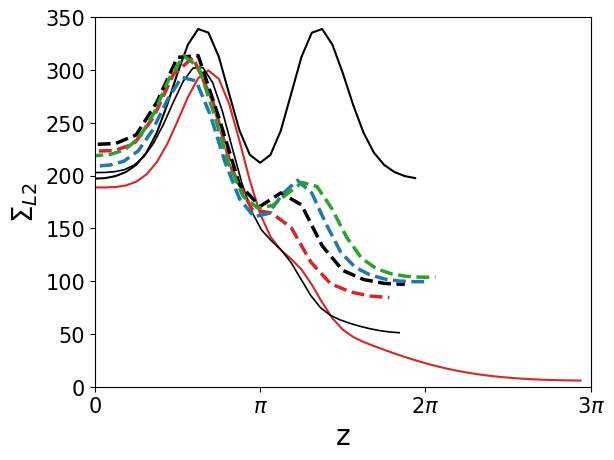

In [ ]:
material_params = {'W':20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1}

system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

linewidth = 1.5

z, ave_activity = get_average_activity(base_flow, material_params, system_params, solver_params, Lz=4*np.pi, Nz=64, suffix='full-periodic-yz', idx_average_over=69, s=-1)
plt.plot(z, ave_activity, color='black', linestyle='-', linewidth=linewidth)

# # Localised
z, activity = get_activity_from_Lz(base_flow, material_params, system_params, solver_params, Lz=3.8*np.pi, Nz=64, suffix='recent-localised-yz')
plt.plot(z, activity, color='black' ,linestyle='-', linewidth=1.2, alpha=1) 
z, activity = get_activity_from_Lz(base_flow, material_params, system_params, solver_params,Lz=6*np.pi, Nz=96, suffix='recent-localised')
activity = standardise(activity, shift=0)
plt.plot(z, activity, color='tab:red', linestyle='-', linewidth=linewidth, alpha=1, zorder=0.1)

# Edge states 
material_params = {'W':20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 32, 'Ny': 32}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1}

system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

z, activity = get_activity_from_Lz(base_flow, fpath="/nfs/st01/hpc-fluids-rrk26/tal43/vKolmogorov3D/edge_track/edge_states/Lz_3,8pi.h5",
                                   material_params=None, system_params=None, solver_params=None,Lz=None, Nz=None, suffix=None)
plt.plot(z, activity, color='tab:red', linestyle='--', linewidth=2.5, alpha=1)
z, activity = get_activity_from_Lz(base_flow, fpath="/nfs/st01/hpc-fluids-rrk26/tal43/vKolmogorov3D/edge_track/edge_states/Lz_4pi.h5",
                                   material_params=None, system_params=None, solver_params=None,Lz=None, Nz=None, suffix=None)
plt.plot(z, activity, color='black', linestyle='--', linewidth=2.5, alpha=1)
z, activity = get_activity_from_Lz(base_flow, fpath="/nfs/st01/hpc-fluids-rrk26/tal43/vKolmogorov3D/edge_track/edge_states/Lz_4,2pi.h5",
                                   material_params=None, system_params=None, solver_params=None,Lz=None, Nz=None, suffix=None)
activity = standardise(activity)
plt.plot(z, activity, color='tab:blue', linestyle='--', linewidth=2.5, alpha=1)
z, activity = get_activity_from_Lz(base_flow, fpath="/nfs/st01/hpc-fluids-rrk26/tal43/vKolmogorov3D/edge_track/edge_states/Lz_4,3pi.h5",
                                   material_params=None, system_params=None, solver_params=None,Lz=None, Nz=None, suffix=None)
plt.plot(z, activity, color='tab:green', linestyle='--', linewidth=2.5, alpha=1)
# plt.vlines(x=0, ymin=0, ymax=900, linestyle='--', color='black', linewidth=1)
# plt.yscale('log')
plt.ylabel(r'$\Sigma_{L2}$', fontsize=20)
plt.xlabel(r'z', fontsize=20)
plt.xticks([0, np.pi, 2*np.pi, 3*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$'], fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3*np.pi)
plt.ylim(0,350)

Big change at s=3...
0.84 0.158347501525084 0.1830489296040405
Big change at s=2...
Big change at s=8...
Big change at s=22...
Big change at s=32...
Big change at s=95...
Big change at s=97...
Big change at s=124...
Big change at s=125...
Big change at s=131...
0.85 0.031082355451332117 0.02523116759484652
Big change at s=2...
Big change at s=9...
Big change at s=26...
Big change at s=38...
0.86 0.011294898263828533 0.014436218210137014
Big change at s=38...
Big change at s=41...
0.87 0.007538161836902317 0.008231540154919151
Big change at s=30...
Big change at s=64...
Big change at s=66...
0.88 0.004300342294251703 0.005059542099394814
Big change at s=30...
Big change at s=65...
Big change at s=67...
0.89 0.002429257799622877 0.0024202143625879414
Big change at s=2...
Big change at s=8...
Big change at s=16...
Big change at s=24...
Big change at s=31...
Big change at s=34...
Big change at s=94...
Big change at s=97...
Big change at s=98...
Big change at s=144...
Big change at s=145...

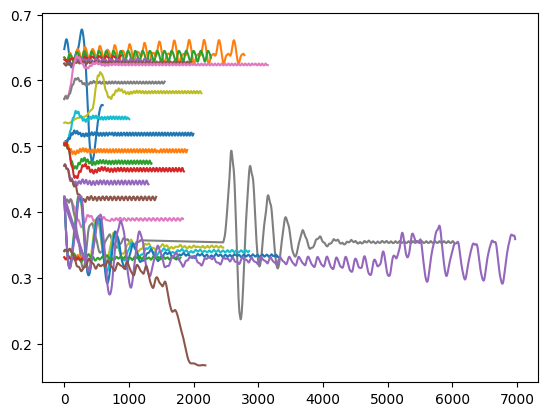

In [7]:
from tools.misc_tools import get_metric_from_params

material_params = {'W':20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1}

mode = 'trace'
Lz_list_plot = np.array([np.pi, 0.9*np.pi,  0.89*np.pi, 0.88*np.pi, 0.87*np.pi, 0.86*np.pi, 0.85*np.pi, 0.84*np.pi][::-1])
Nz_list =               [ 32,     32,   32,       32, 32, 32 ,    32, 32, 32, 32, 32]

for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='long-below-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
    plt.plot(t_all-t_all[0], metric_all)
    metric_mean, metric_max, metric_min = get_mean_max_min(t_all, metric_all)
    print(Lz/np.pi, (metric_max-metric_mean)/metric_mean, (metric_mean-metric_min)/metric_mean)
Lz_list_plot = np.array([ 1.06*np.pi, 1.25*np.pi, 1.4*np.pi, 1.6*np.pi, 1.8*np.pi,  2*np.pi, 2.5*np.pi, 3*np.pi, 3.5*np.pi, 4*np.pi, 4.1*np.pi, 4.2*np.pi, 4.3*np.pi, 4.33*np.pi, 4.35*np.pi, 4.37*np.pi, 4.4*np.pi, 4.5*np.pi])
Nz_list =               [    32,         32,         32,        32,          32    ,  64,         64,         64,           64,    64,  96, 96, 96, 96, 96, 96, 96, 96]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='long-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
    plt.plot(t_all-t_all[0], metric_all)
    metric_mean, metric_max, metric_min = get_mean_max_min(t_all, metric_all)
    print(Lz/np.pi, (metric_max-metric_mean)/metric_mean, (metric_mean-metric_min)/metric_mean)


Big change at s=218...
Big change at s=612...
Big change at s=688...
4.4 0.031192860714566676 0.026845861002243735
4.5 0.0289985993365089 0.030362852058632518


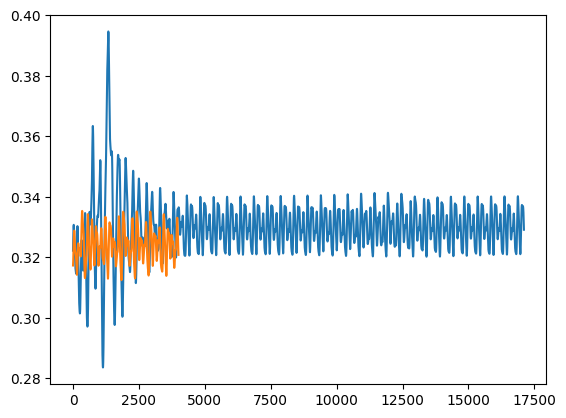

In [18]:
material_params = {'W':20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 32, 'Ny': 32}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1}

Lz_list_plot = np.array([  4.4*np.pi, 4.5*np.pi])
Nz_list =               [ 48,48]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='long-periodic-yz', subdir='arrowhead_3D', metric=mode, deviation=True)
    plt.plot(t_all-t_all[0], metric_all)
    metric_mean, metric_max, metric_min = get_mean_max_min(t_all, metric_all)
    print(Lz/np.pi, (metric_max-metric_mean)/metric_mean, (metric_mean-metric_min)/metric_mean)
# plt.xlim(0,6000)